# Cálculo do R_t
---


- Notebook adaptado de: https://github.com/loft-br/realtime_r0_brazil/blob/master/realtime_r0_bettencourt_ribeiro.ipynb*

- Modelo de [Kevin Systrom](http://systrom.com/blog/the-metric-we-need-to-manage-covid-19/) baseado em: 
  - *Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases*. Bettencourt LMA, Ribeiro RM (2008) Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases. PLOS ONE 3(5): e2185. https://doi.org/10.1371/journal.pone.0002185

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import packages</a></span><ul class="toc-item"><li><span><a href="#Import-config" data-toc-modified-id="Import-config-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import config</a></span></li></ul></li><li><span><a href="#Import-model" data-toc-modified-id="Import-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import model</a></span></li><li><span><a href="#Import-data" data-toc-modified-id="Import-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Import data</a></span></li><li><span><a href="#Run-state-model" data-toc-modified-id="Run-state-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Run state model</a></span></li><li><span><a href="#Draft" data-toc-modified-id="Draft-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Draft</a></span></li></ul></div>

## Import packages

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

import warnings
warnings.filterwarnings('ignore')
""
# Plotting
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Centering and fixing title
def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))

# Adding custom colorscales (to add one: themes/custom_colorscales.yaml)
import yaml

In [13]:
import requests
from matplotlib import pyplot as plt

# importando joblib para rodar em paralelo
from joblib import Parallel, delayed
from model import run_full_model, load_data, plot_rt, plot_standings

# número de cores para paralelizar modelo nos estados
N_JOBS = -1

In [15]:
from src.loader import get_cases
from src.loader.utils import get_config

### Import config

In [16]:
config_url = get_config("https://raw.githubusercontent.com/ImpulsoGov/simulacovid/master/src/configs/config.yaml")

df = get_cases.now('br',
                   config_url,
                   last=False)

## Import model

> Vamos reproduzir o modelo do Kevin Systrom, baseado no artigo de Bettencourt & Ribeiro, para estimarmos $R_t$, o número de reprodução eficaz, para os estados brasileiros.
> 
> **Ajuste do modelo**
>
> Ajustamos um modelo bayesiano simples, assumindo que os dados de novos casos assumem uma distribuição Poisson parametrizada por $\lambda$ e a seguinte fórmula para a conexão entre $R_t$ e $\lambda$ (segundo este artigo):
>
> $$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$
>
> onde $\gamma$ é a recíproca do serial interval (em torno de 7 dias para o COVID19) e $k_{t-1}$ é o número de novos casos para o dia anterior. Abaixo rodamos a função run_full_model para todos os estados em paralelo. Mais detalhes no notebook do Kevin.

In [17]:
model_url = 'thttps://raw.githubusercontent.com/loft-br/realtime_r0_brazil/master/core.py'
# model_entrypoint = ''

open('model.py', 'w').write(requests.get(model_url).text)

## Import data

* Model input:

In [70]:
### reading data ###

# lendo do repositório do Wesley Cota
city_df, state_df = load_data()

In [71]:
city_df = city_df['confirmed_new']
city_df

city           date      
Abaetetuba/PA  2020-03-31    1
               2020-04-01    0
               2020-04-02    0
               2020-04-03    0
               2020-04-04    0
                            ..
Óbidos/PA      2020-04-30    1
               2020-05-01    0
               2020-05-02    0
               2020-05-03    0
               2020-05-04    0
Name: confirmed_new, Length: 50201, dtype: int64

In [72]:
state_df = state_df['confirmed_new']
state_df

state  date      
AC     2020-03-17     3
       2020-03-18     0
       2020-03-19     1
       2020-03-20     3
       2020-03-21     4
                     ..
TO     2020-04-30    27
       2020-05-01    27
       2020-05-02    55
       2020-05-03     0
       2020-05-04    21
Name: confirmed_new, Length: 1498, dtype: int64

* Our input:

In [39]:
from src.loader import get_cases

In [55]:
rename = {'city_id': 'city', 
          'last_updated': 'date'}

In [95]:
df['adjusted_daily_cases'] = df['daily_cases'].fillna(0) / df['notification_rate']

In [96]:
city_df = df[~df['adjusted_daily_cases'].isnull()][['city_id', 'last_updated', 'adjusted_daily_cases']]\
            .rename(rename, axis=1)\
            .groupby(['city', 'date'])['adjusted_daily_cases']\
            .sum().round(0)

city_df.name = 'confirmed_new'

In [97]:
city_df

city     date      
1100015  2020-05-02      1.0
         2020-05-03      0.0
         2020-05-04      0.0
1100023  2020-04-10      6.0
         2020-04-11      0.0
                       ...  
5300108  2020-04-30    131.0
         2020-05-01    139.0
         2020-05-02     73.0
         2020-05-03    106.0
         2020-05-04      0.0
Name: confirmed_new, Length: 45501, dtype: float64

In [105]:
state_df = df[~df['adjusted_daily_cases'].isnull()][['state', 'last_updated', 'adjusted_daily_cases']]\
            .rename(rename, axis=1)\
            .groupby(['state', 'date'])['adjusted_daily_cases']\
            .sum().round(0)

state_df.name = 'confirmed_new'

In [106]:
state_df

state  date      
AC     2020-04-12     8.0
       2020-04-13    24.0
       2020-04-14    16.0
       2020-04-15     4.0
       2020-04-16    26.0
                     ... 
TO     2020-04-30    69.0
       2020-05-01    32.0
       2020-05-02    85.0
       2020-05-03     0.0
       2020-05-04     0.0
Name: confirmed_new, Length: 833, dtype: float64

## Run state model

* Debug: which ones doesn't work?

In [146]:
states = state_df.index.get_level_values('state').unique()

for state in states:
    
    sample = state_df.iloc[state_df.index.get_level_values('state').isin([state])]
    
    try:
        with Parallel(n_jobs=1) as parallel:
            results = parallel(delayed(run_full_model)(grp[1], sigma=0.01) for grp in sample.groupby(level='state'))
    except:
        print(state)

RN


In [152]:
state_df[state_df.index.get_level_values('state') == 'RN']

state  date      
RN     2020-04-03    110.0
       2020-04-04      0.0
       2020-04-05    128.0
       2020-04-06      0.0
       2020-04-07     16.0
       2020-04-08      4.0
       2020-04-09      0.0
       2020-04-10      4.0
       2020-04-11     41.0
       2020-04-12    160.0
       2020-04-13     65.0
       2020-04-14     58.0
       2020-04-15      1.0
       2020-04-16    127.0
       2020-04-17    101.0
       2020-04-18     88.0
       2020-04-19     73.0
       2020-04-20     43.0
       2020-04-21     75.0
       2020-04-22    145.0
       2020-04-23     78.0
       2020-04-24     52.0
       2020-04-25     79.0
       2020-04-26     31.0
       2020-04-27     61.0
       2020-04-28    665.0
       2020-04-29    220.0
       2020-04-30    253.0
       2020-05-01      0.0
       2020-05-02      0.0
       2020-05-03      0.0
       2020-05-04      0.0
Name: confirmed_new, dtype: float64

* Running without state error

In [148]:
sample = state_df.iloc[state_df.index.get_level_values('state').isin([i for i in states if i != 'RN'])] 
sample

state  date      
AC     2020-04-12     8.0
       2020-04-13    24.0
       2020-04-14    16.0
       2020-04-15     4.0
       2020-04-16    26.0
                     ... 
TO     2020-04-30    69.0
       2020-05-01    32.0
       2020-05-02    85.0
       2020-05-03     0.0
       2020-05-04     0.0
Name: confirmed_new, Length: 801, dtype: float64

In [149]:
with Parallel(n_jobs=1) as parallel:
    results = parallel(delayed(run_full_model)(grp[1], sigma=0.01) for grp in sample.groupby(level='state'))

final_results = pd.concat(results)

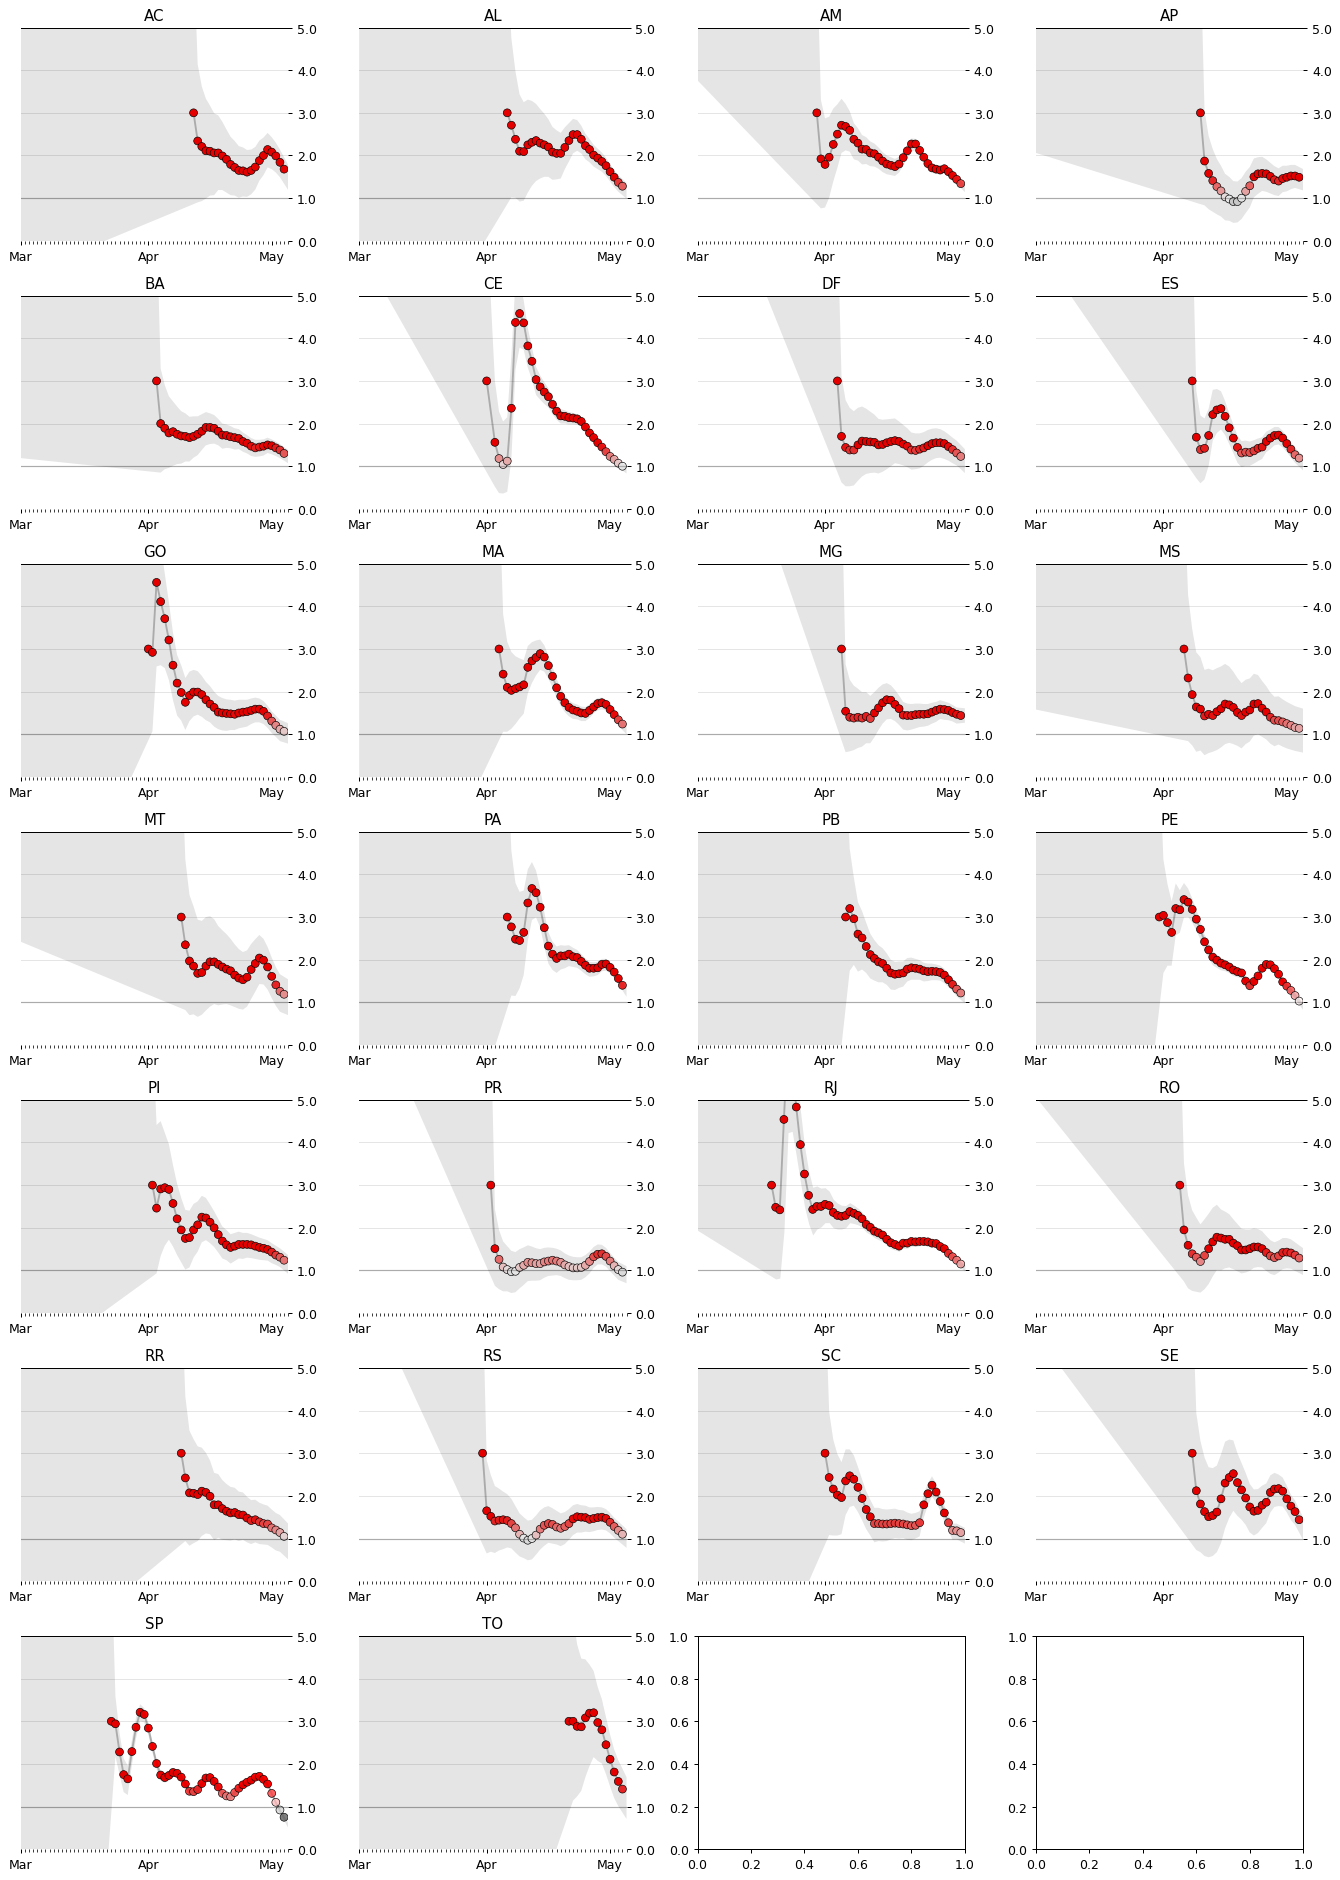

In [150]:
def plot_rt_states():

    # number of columns and rows for plotting
    N_COLS = 4
    N_ROWS = int(np.ceil(len(results) / N_COLS))

    # opening figura
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(15, N_ROWS*3), dpi=90)

    # loop for several states
    for i, (state_name, result) in enumerate(final_results.groupby('state')):
        plot_rt(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

plot_rt_states()

## Draft

In [19]:
# lendo do repositório do Wesley Cota
city_df, state_df = load_data()

In [20]:
city_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50201 entries, ('Abaetetuba/PA', Timestamp('2020-03-31 00:00:00')) to ('Óbidos/PA', Timestamp('2020-05-04 00:00:00'))
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   deaths_new                       50201 non-null  int64  
 1   deaths_total                     50201 non-null  int64  
 2   confirmed_new                    50201 non-null  int64  
 3   confirmed_total                  50201 non-null  int64  
 4   deaths_per_100k_inhabitants      50201 non-null  float64
 5   totalCases_per_100k_inhabitants  50201 non-null  float64
 6   deaths_by_totalCases             50201 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 2.8+ MB


In [21]:
city_df[city_df['deaths_total'] > 100]

deaths_new  deaths_total  confirmed_new  \
city         date                                                  
Belém/PA     2020-04-30          50           139            171   
             2020-05-01          17           156            134   
             2020-05-02          22           178            188   
             2020-05-03           2           180             42   
             2020-05-04           0           180              0   
...                             ...           ...            ...   
São Paulo/SP 2020-04-30          83          1522           1511   
             2020-05-01          85          1607            938   
             2020-05-02          54          1661            407   
             2020-05-03          12          1673            328   
             2020-05-04           0          1673              0   

                         confirmed_total  deaths_per_100k_inhabitants  \
city         date                                                       
Belém/PA     2020-04-30             1658                      9.31170   
             2020-05-01             1792                     10.45055   
             2020-05-02             1980                     11.92434   
             2020-05-03             2022                     12.05832   
             2020-05-04             2022                     12.05832   
...                                  ...                          ...   
São Paulo/SP 2020-04-30            18149                     12.42244   
             2020-05-01            19087                     13.11620   
             2020-05-02            19494                     13.55694   
             2020-05-03            19822                     13.65489   
             2020-05-04            19822                     13.65489   

                         totalCases_per_100k_inhabitants  deaths_by_totalCases  
city         date                                                               
Belém/PA     2020-04-30                        111.07054               0.08384  
             2020-05-01                        120.04730               0.08705  
             2020-05-02                        132.64154               0.08990  
             2020-05-03                        135.45515               0.08902  
             2020-05-04                        135.45515               0.08902  
...                                                  ...                   ...  
São Paulo/SP 2020-04-30                        148.13064               0.08386  
             2020-05-01                        155.78652               0.08419  
             2020-05-02                        159.10842               0.08521  
             2020-05-03                        161.78553               0.08440  
             2020-05-04                        161.78553               0.08440  

[162 rows x 7 columns]

In [23]:
s = (
    city_df.reset_index()[['deaths_total', 'city']]
    .query('city != "Brazil"').query('deaths_total > 0')
    .groupby(['city']).max()
    .sort_values(by='deaths_total', ascending=False)
    .cumsum()
    .reset_index(drop=True)
)

s = s.divide(s.max()) * 100
# s.iplot(
#           title='80% das mortes ocorreram em 79 municípios',
#           xTitle='# de Municípios',
#            yTitle='% das Mortes',
#            theme='white',
#            bins=100,
#             width=5,
#         dimensions=(500,500)
#           )

In [24]:
s

,deaths_total
0,22.886457
1,31.518468
2,38.741450
3,44.158687
4,47.811218
...,...
772,99.945280
773,99.958960
774,99.972640
775,99.986320


In [25]:
s = (
    city_df.reset_index()[['deaths_total', 'city']]
    .query('city != "Brazil"').query('deaths_total > 0')
    .groupby(['city']).max()
    .sort_values(by='deaths_total')
    .reset_index(drop=True)
)
deaths = s['deaths_total']
s['cities'] = s.index #/ s.index.max() * 100
s = s.sort_values(by='cities', ascending=False).drop('deaths_total', 1)
s.index = deaths
# s.iplot(
#           title='$$\\text{Uma linda curva que segue } x^{-\\beta}$$',
#           yTitle='# de Municípios com menos de X mortes',
#            xTitle='# de Mortes',
#            theme='white',
#            bins=100,
#         width=5,
#         xaxis_type="log", yaxis_type="log",
#         dimensions=(500,500)
#           )

In [26]:
sample = city_df.query('deaths_total > 20')['deaths_new']

In [27]:
sample.groupby(level='city').count()

city
Belém/PA                            18
Brasília/DF                         18
Brazil                              44
CASO SEM LOCALIZAÇÃO DEFINIDA/AM     1
CASO SEM LOCALIZAÇÃO DEFINIDA/PE     2
CASO SEM LOCALIZAÇÃO DEFINIDA/RJ     1
CASO SEM LOCALIZAÇÃO DEFINIDA/SP     4
Camaragibe/PE                        3
Campinas/SP                          2
Curitiba/PR                          4
Diadema/SP                           4
Duque de Caxias/RJ                  19
Fortaleza/CE                        30
Guarulhos/SP                        20
Jaboatão dos Guararapes/PE          14
João Pessoa/PB                      14
Macapá/AP                            7
Maceió/AL                            8
Manacapuru/AM                        7
Manaus/AM                           27
Mauá/SP                              4
Mogi das Cruzes/SP                   4
Niterói/RJ                           5
Nova Iguaçu/RJ                      11
Olinda/PE                           14
Osasco/SP           

In [35]:
with Parallel(n_jobs=1) as parallel:
    results = parallel(delayed(run_full_model)(grp[1], sigma=0.01) for grp in sample.groupby(level='city'))

final_results = pd.concat(results)

IndexError: index 0 is out of bounds for axis 0 with size 0

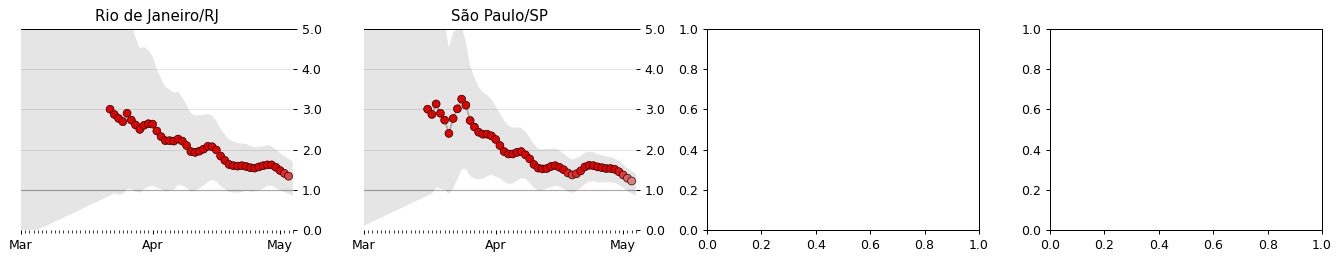

In [65]:
def plot_rt_states():

    # number of columns and rows for plotting
    N_COLS = 4
    N_ROWS = int(np.ceil(len(results) / N_COLS))

    # opening figura
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(15, N_ROWS*3), dpi=90)

    # loop for several states
    for i, (state_name, result) in enumerate(final_results.groupby('city')):
        plot_rt(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

plot_rt_states()